
=== 이미지 특성 데이터 ===
         이름       첫번째_고유값     두번째_고유값     평균_알파
7   adipose   1778.601903   41.449228  0.147315
8   adipose    611.930800   21.083529  0.119599
12  adipose   1251.104586   33.924698  0.158396
13  adipose    772.728924   30.500090  0.131351
4      back      0.115052    0.017255  0.047062
10     back      0.042289    0.007685  0.047059
11     back      0.150185    0.033560  0.047040
14     back      0.602182    0.150464  0.046774
2   marking   1154.784042   43.761992  0.751543
3   marking   4700.892072   50.444172  0.825105
6   marking   1800.993178   20.891540  0.849873
15  marking   2752.390906   22.075800  0.828891
0    tissue  12761.062755  167.183333  0.478328
1    tissue  11915.243568  212.366742  0.513290
5    tissue  17002.071843  179.948859  0.360588
9    tissue  12154.869593  204.171518  0.437273


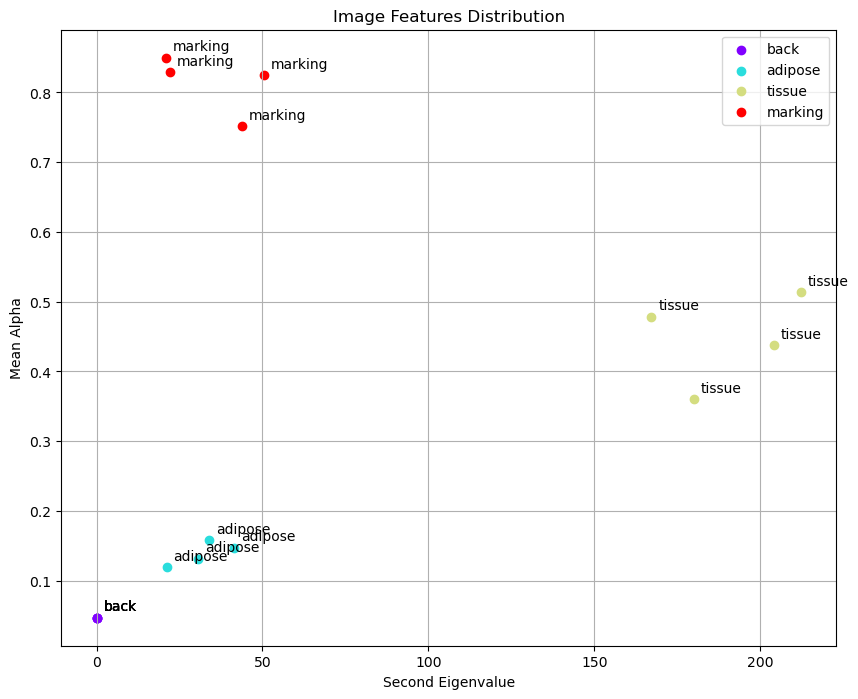

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import re
import pandas as pd

def get_image_features(image_path):
    img = cv2.imread(image_path)
    # RGB로 변환
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pixels_img = np.array(img).reshape(-1, 3)
    
    # 공분산 행렬
    cov_matrix = np.cov(pixels_img.T)
    mu = np.mean(pixels_img, axis=0)
    
    # RGB 채널별 평균 계산
    mean = np.mean(mu)
    mean_alpha = (255-mean) / 255
    
    
    # 고유값과 고유벡터 계산
    eigvals, eigvecs = np.linalg.eig(cov_matrix)
    
    # 고유값 정렬 (내림차순)
    sort_indices = np.argsort(eigvals)[::-1]
    sort_eigvals = eigvals[sort_indices]
    sort_eigvecs = eigvecs[:, sort_indices]

    # 두 번째 고유치
    eig_1 = sort_eigvals[0]
    eig_2 = sort_eigvals[1]
    
    return eig_1, eig_2, mean_alpha

def extract_name(filename):
    # 파일명에서 좌표까지 포함하여 추출하도록 수정
    pattern = r"([^_]+)_patch_(\d+)_(\d+)\.png"
    match = re.match(pattern, filename)
    if match:
        return match.group(1), int(match.group(2)), int(match.group(3))
    return None, None, None

def create_plot(folder_path):
    # 데이터 수집
    data = []
    names = set()
    
    # DataFrame을 위한 리스트
    df_data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            name, x_coord, y_coord = extract_name(filename)
            if name:
                image_path = os.path.join(folder_path, filename)
                eig_1, eig_2, mean_alpha = get_image_features(image_path)
                
                # 이름_x좌표_y좌표 형식으로 변경
                full_name = f"{name}"
                data.append((full_name, eig_2, mean_alpha))
                names.add(name)
                
                # DataFrame 데이터 추가
                df_data.append({
                    '이름': full_name,
                    '첫번째_고유값': eig_1,
                    '두번째_고유값': eig_2,
                    '평균_알파': mean_alpha
                })
    
    # DataFrame 생성 및 정렬
    df = pd.DataFrame(df_data)
    df = df.sort_values(['이름'])
    
    # DataFrame 출력
    print("\n=== 이미지 특성 데이터 ===")
    print(df)
    
    # CSV 파일로 저장
    df.to_csv('image_features.csv', index=False, encoding='utf-8-sig')
    
    # 각 이름별로 다른 색상 할당
    colors = plt.cm.rainbow(np.linspace(0, 1, len(names)))
    name_to_color = dict(zip(names, colors))
    
    # 플롯 생성
    plt.figure(figsize=(10, 8))
    for full_name, eig_2, mean_alpha in data:
        base_name = full_name.split('_')[0]
        plt.scatter(eig_2, mean_alpha, color=name_to_color[base_name])
        plt.annotate(full_name, (eig_2, mean_alpha), xytext=(5, 5), textcoords='offset points')
    
    # 중복되는 레이블 제거
    handles = [plt.scatter([], [], color=color, label=name) for name, color in name_to_color.items()]
    plt.legend(handles=handles)
    
    plt.xlabel('Second Eigenvalue')
    plt.ylabel('Mean Alpha')
    plt.title('Image Features Distribution')
    plt.grid(True)
    plt.show()

# 사용 예시
folder_path = "/home/dororo99/prof_task/analyze2/imgs"  # 실제 이미지 폴더 경로로 변경하세요
create_plot(folder_path)